# Impact of social distancing measure in COVID-2019's spread using SEIR model

note by [YY Khoo](http://yy-khoo.com/) (2020)

This notebook is my first attempt to use the [compartmental models in epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). This work is inspired largely by recent outbreak in COVID-19 and [this](https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296) article. This model is merely a draft and should not be used for projection!

The [SEIR model](https://idmod.org/docs/malaria/model-seir.html) is a model used to model infectious disease. The name itself is an acronym for Susceptible, Exposed, Infected, Recovered. When a virus is introduced to a population, an infected person may move from one location to another (also known as from one compartment to another compartment). This movement will move the virus throughout the population. The full model is as below, for S being fraction of population being susceptible, E being exposed, I for infected, and R for recovered.

$$
\begin{align}
\frac{dS}{dt} &= -\beta SI \\
\frac{dE}{dt} &= \beta SI - \alpha E \\
\frac{dI}{dt} &= \alpha E - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{align}
$$

There are 3 factors in these Odinary Differential Equations, which we will investigate them one by one. 

1. $\alpha$ is the inverse of incubation time. From recent researches, we can estimate the incubation time for COVID-19 to be 5 days. 

2. $\beta$ on the other hand is the average contact rate in the population. It is given by $\beta = \frac{R_0}{\gamma}$, where $R_0$ is the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number) of the disease. For COVID-19, the virus is estimated to have an $R_0$ of around 1.4 - 3.9. For this simulation let's take 3.9.

3. $\gamma$ is the inverse of mean infection period. This is a tough to estimate parameter and we'll be using 0.5, as suggested by [other researches](https://arxiv.org/pdf/2002.06563.pdf).

To build the simulation, let's first define a function that solves the ODEs. The ODEs can be easily solved using [Euler's method](https://en.wikipedia.org/wiki/Euler_method). With these in mind, we define the function "RunSIER".


In [1]:
#Start by importing tools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#we first build the model using forward Euler's method.
def RunSIER(state0, params, t):
    S0, E0, I0, R0 = state0
    S, E, I, R = [S0], [E0], [I0], [R0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    
    #loop through the computation, using Euler's method to solve ODE
    #this is quick, but waste computation power by moving the arrays over & over again
    for _ in t[1:]:
        nextS = S[-1] - (beta * S[-1] * I[-1]) * dt
        nextE = E[-1] + (beta * S[-1] * I[-1] - alpha * E[-1]) * dt
        nextI = I[-1] + (alpha * E[-1] - gamma * I[-1]) * dt
        nextR = R[-1] + (gamma * I[-1]) * dt
        S.append(nextS)
        E.append(nextE)
        I.append(nextI)
        R.append(nextR)
        
    #return results
    return np.stack([S, E, I, R]).T

Now with the function in place, let's try to simulate the model with default parameters we have choosen.

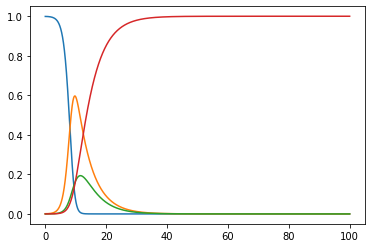

In [3]:
#define simulation parm
t_max = 100
dt = 0.01

#define initial state
t = np.linspace(0, t_max, int(t_max/dt) + 1) #each timestep is...
N = 1000 #number of people in population
state0 = 1 - 1/N, 1/N, 0, 0 #Susceptible, Exposed, Infected, Recovered. Initially, 1 exposed, others susceptible, no recoveries. Normalized

#define growth factors / parameters
alpha = 0.2 #alpha = 1/(incubation time). E.g. 5 days
gamma = 1.0/ 2.0 #gamma = 1/(mean infectious period)
beta = 3.9 / gamma #beta = infectious rate. R0 = beta/gamma (R0 is the "basic reproduction number"). Assume R0 = 3.9; 

#run simulation
params = alpha, beta, gamma
results = RunSIER(state0, params, t)

#and finally graphing the result
fig = plt.figure()
ax = plt.axes()
ax.plot(t, results);

From the simulation, it seems the entire population (100%) will be infected, leaving no susceptible compartments (see blue line). The rate of peak infection is at around 15d, with 60% compartments are exposed and 20% infection rate. 

It's obvious that with no intervention whatsoever, the coronavirus will spread throughout the entire population. Currently (25 Mar 2020), there are [lots of cities](https://www.businessinsider.my/countries-on-lockdown-coronavirus-italy-2020-3?r=US&IR=T) that had went into social distancing or lock down orders. The chief idea is to retard the virus's spread, and thus reducing the number of exposed & infected patient. From a modelling standpoint, it is interesting to understand the impact of social distancing. In SEIR model, the social distancing measure will impact the infectious rate, $\beta$. To see how it's impacted, let us half the infectious rate by adding a new factor, $\delta$ = 0.5.

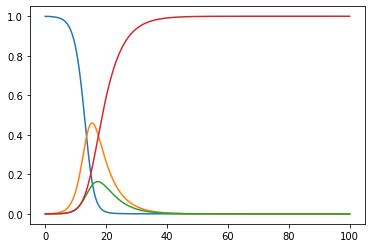

In [4]:
#define growth factors / parameters
alpha = 1.0 / 5.0
gamma = 1.0/ 2.0 
beta = 3.9 / gamma *0.5 #the infectious rate is halved to see the impact of social distancing

#run simulation
params = alpha, beta, gamma
results2 = RunSIER(state0, params, t)

#plotting graph
fig = plt.figure()
ax = plt.axes()
ax.plot(t, results2);

It seems that the virus is still potent enough to infect the entire population. However, the peak infection rate had reduced and shifted slightly to the right side. This shift of peak infection rate will buy our healthcare system some time, and avoid overcrowding the healthcare system. This is what everyone been talking about when they wanted to ["flatten the curve"](https://www.npr.org/sections/coronavirus-live-updates/2020/03/26/822130807/-glimmer-of-hope-when-can-we-say-social-distancing-is-working). 

To visualize the flattening of curve further, we run several simulations and superimpose the graphs together.

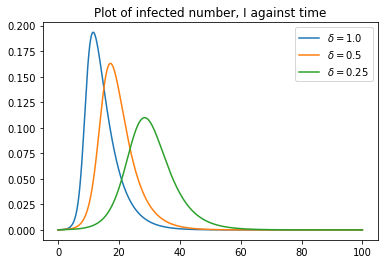

In [5]:
#define growth factors / parameters
alpha = 1.0 / 5.0
gamma = 1.0/ 2.0
beta = 3.9 / gamma * 0.25

#run simulation
params = alpha, beta, gamma
results3 = RunSIER(state0, params, t)

#plotting graph
fig = plt.figure()
ax = plt.axes()
ax.plot(t, results[:,2],label='$\delta=1.0$')
ax.plot(t, results2[:,2],label='$\delta=0.5$')
ax.plot(t, results3[:,2],label='$\delta=0.25$')
plt.title('Plot of infected number, I against time')
ax.legend();


From the SEIR model without any social distancing measure, it seems that everyone in the population will be infected. However, with social distancing measure, the virus couldn't infect everyone. This can be seen in the graph of susceptible population against time, where it flatlines at > 0 percent of population.

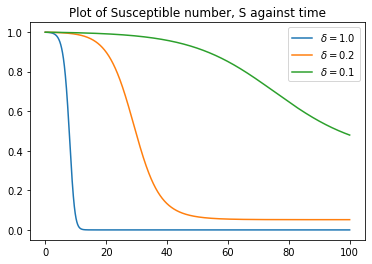

In [6]:
beta = 3.9 / gamma * 0.2
params = alpha, beta, gamma
results2 = RunSIER(state0, params, t)

beta = 3.9 / gamma * 0.1
params = alpha, beta, gamma
results3 = RunSIER(state0, params, t)

#plotting graph
fig = plt.figure()
ax = plt.axes()
ax.plot(t, results[:,0],label='$\delta=1.0$')
ax.plot(t, results2[:,0],label='$\delta=0.2$')
ax.plot(t, results3[:,0],label='$\delta=0.1$')
plt.title('Plot of Susceptible number, S against time')
ax.legend();

With stringent social distancing, it is likely that the $\delta$ factor can be lower, which severely retards the virus's spread. 